## Explore Quantum Money by demonstrating the Weisner Protocol

The process of building and verifying a quantum note with the Weisner Protocol is a process similar to BB84 QKD Scheme, but can give provide good insight into the use of no-cloning theorem in quantum cryptography

### Objectives
<ol>
<li>Show the building of a note by a Bank</li>
<li>Show the verfication process of a valid note by a Bank</li>
<li>Show a forgery attempt by an Adversary (including failed verification)</li>
<li>Discuss Drawbacks of weisner scheme</li>
<li>Break/Forge Weisner notes if bank returns invalid notes</li>
<ul>
<li>Show the standard trial and error attack (bank can detect forgeries)</li>
<li>Show an adaptive attack (bank can't detect with high prob )</li>
</ul>
</ol>

##### References:
<ul>
    <li>https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html</li>
    <li>Brodutch, Aharon, et al. "An adaptive attack on Wiesner's quantum money." arXiv preprint arXiv:1404.1507 (2014)</li>
</ul>

In [1]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from numpy.random import randint
import numpy as np

#### Encoding qubits in different bases

In [2]:
def gen_rand_bit_str(n):
    return randint(2, size=n)

def encode_qubits(bits, bases, print_circ = False):
    n = len(bits)
    qubits = QuantumCircuit(n, n)
    for i in range(n):
        # The starting bit is 0 in standard basis
         
        if bases[i] == 0 and bits[i] == 1: # If 1 in standard basis
                qubits.x(i)
        
        elif bases[i] == 1: # If in H basis
            if bits[i] == 1: # to make |-> 
                qubits.x(i)
            qubits.h(i)
    
    if print_circ:
        qubits.draw(output='mpl')
    
    return qubits

#### Measuring in different bases

In [3]:
def measure_in_H(qc, qubit_idx = 0, target_idx = 0):
    qc.h(qubit_idx)
    qc.measure(qubit_idx, target_idx)
    qc.h(qubit_idx)
    return qc

def measure_in_S(qc, qubit_idx = 0, target_idx = 0):
    qc.measure(qubit_idx, target_idx)
    return qc

In [4]:
def measure_qubits(qubits, bases):
    backend = Aer.get_backend('qasm_simulator')
    n = len(bases)
    measured_bits = np.zeros(n, dtype=int)
    
    for i in range(n):
        if bases[i] == 0: # measuring in Standard Basis
            measure_in_S(qubits, i, qubits.num_clbits-i-1)
        else: # measuring in H Basis
            measure_in_H(qubits, i, qubits.num_clbits-i-1)
        
    result = execute(qubits, backend, shots=1, memory=True).result()

    bits_str = result.get_memory()
    
    for i in range(len(bases)):
        measured_bits[i] = int(bits_str[0][i])
    
    return measured_bits

### Quantum Bank Notes

A Quantum Bank Note (represented by class Qnote in the code) is a collection of a serial number s, and an ordered list of (initialized) qubits. 

    Qnote = (s, qubits)

The serial number allows the bank to reference and obtain the verification protocol associated with the coin, i.e; it allows the bank to find out the correct bits and bases in which the qubits are encoded

In [5]:
class Qnote:
    def __init__(self, ser_no, qubits):
        self.ser_no = ser_no
        self.qubits = qubits

### Bank

For simplicity, our bank uses a private encrpytion method to store the correct bits/bases associated with a serial method (the serial no. is produced randomly and stored in a large list, called a note ledger here, along with the correct bits/bases which can only be accessed by the bank)

The bank can create new notes, and keep track of the bits and bases used as well as the associated serial no. Since here, the serial no. production is random, this is informationally secure. 

Then, given a bank note, the bank can retrieve the correct bits and bases associated with the serial no., perform measurements on the note and hence verify its validity

In this instance, the bank returns the notes post measurement, wheter it was verified or not. If a valid note was passed, the correct measurement should leave its state unchanged

In [6]:
class Bank:
    def __init__(self):
        self.note_ledger = dict()
    
    def make_note(self, n, print_bb = False):
        ser_no = randint(4**n)
        
        bits = gen_rand_bit_str(n)
        bases = gen_rand_bit_str(n)
        
        if(print_bb):
            print('note Serial No. = %i' % ser_no)
            print('    bits  =', bits)
            print('    bases =', bases)
        
        self.note_ledger[ser_no] = (bits, bases)
        qubits = encode_qubits(bits, bases)
        qubits.barrier()
        
        return Qnote(ser_no, qubits)
    
    def verify_note(self, Qnote, print_res = False):
        true_bits  = self.note_ledger[Qnote.ser_no][0]
        true_bases = self.note_ledger[Qnote.ser_no][1]
        
        note_bits = measure_qubits(Qnote.qubits, true_bases)
        Qnote.qubits.barrier()
        isRealnote = (note_bits == true_bits).all()
        
        if print_res:
            if isRealnote:
                print("The Bank has verified your note to be real. Here is your note back!")
            else:
                print("Invalid note detected! Keep it with yourself.")
        
        return Qnote, isRealnote

### Production Example

In [7]:
mybank = Bank()
n = 10

newnote = mybank.make_note(n, print_bb = True)
print("\nCurrent note Ledger = ", mybank.note_ledger)

note Serial No. = 613844
    bits  = [1 0 1 0 1 1 0 1 1 1]
    bases = [0 0 0 1 1 0 0 0 1 0]

Current note Ledger =  {613844: (array([1, 0, 1, 0, 1, 1, 0, 1, 1, 1]), array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0]))}


### Verification Example

In [8]:
verified_note, _ = mybank.verify_note(newnote, print_res = True)

The Bank has verified your note to be real. Here is your note back!


### Invalid Notes Example

In [9]:
stolen_ser_no   = newnote.ser_no

attacker_bits   = gen_rand_bit_str(n)
attacker_bases  = gen_rand_bit_str(n)

attacker_qubits = encode_qubits(attacker_bits , attacker_bases)
attacker_note   = Qnote(stolen_ser_no, attacker_qubits)

incorrect_note,_= mybank.verify_note(attacker_note, print_res = True) 

Invalid note detected! Keep it with yourself.


### Tampering Example

In [10]:
stolen_ser_no   = newnote.ser_no

attacker_bases  = np.zeros(n, dtype=int)
attacker_bits   = measure_qubits(newnote.qubits, attacker_bases)

attacker_qubits = encode_qubits(attacker_bits , attacker_bases)
attacker_note   = Qnote(stolen_ser_no, attacker_qubits)

incorrect_note,_= mybank.verify_note(attacker_note, print_res = True) 
tampered_note, _= mybank.verify_note(newnote, print_res = True) 

Invalid note detected! Keep it with yourself.
Invalid note detected! Keep it with yourself.


### Drawbacks of the Weisner Scheme

<ul>
    <li>Storing the correct bits/bases in a large list can be inefficient if many notes are to be produced<\li>
    <li>Only the bank may verify a note, i.e: this is private encryption, not public<\li>
    <li>Carrying around physical qubits is not easy/feasible<\li>
    <li>If a bank returns the post measurement notes, then forgeries can be produced<\li>
<\ul>

### Forgery Attempt 1 (Trial and Error attack)

If a bank returns the post measurement bank notes after verification (successful or not), then, the note can be forged as follows:

Starting with the first qubit of the bank note:
<ul>
<li>Replace that qubit with a known state</li>
<li>Ask the bank to the verification protocol</li>
<li>Change state and start over if incorrect</li>
<li>If verification passed, move on and repeat with the next qubit</li>
</ul>
   
If verification protocol is run a sufficient amount of times, then, the correct arrangement of bits and bases can be figured out 

In this attempt, the bank is able to verify and reject forged notes, so there is a possibility of getting caught)

In [11]:
from copy import deepcopy

#### Bank prints a new note ####
mybank = Bank()
n = 10

newnote = mybank.make_note(n, print_bb = True)

#### Attacker gets that note ####
note_to_copy  = deepcopy(newnote)
stolen_ser_no = newnote.ser_no

#### Attacker gets ready to "copy" ####
correct_bits   = np.zeros(n, dtype=int)
correct_bases  = np.zeros(n, dtype=int)

# We go over every qubit
for i in range(n):
    test_qubits = note_to_copy.qubits  # These are the qubits from the note we want to forge
    
    # Let |a> be the qubit of the bank note we wish to determine
    
    # We go over each possible arrangement of basis and qubit state
    guesses = [ (0,0), (0,1), (1,0), (1,1) ]
    for guess in guesses:
        ############## Encoding qubit i with guess ############
        test_qubits.reset(i) # This resets |a> to |0>
        
        basis = guess[1]
        bit   = guess[0]
        
        if basis == 0 and bit == 1: # If 1 in standard basis
                test_qubits.x(i) # Sets |a> to |1>
        
        elif basis == 1: # If in H basis (|+> or |->)
            if bit == 1: # to make |-> 
                test_qubits.x(i)
            test_qubits.h(i)
        ########################################################
        
        #### The Bank is called to verify our guess ####
        _,ver_passed = mybank.verify_note(Qnote(stolen_ser_no, test_qubits))
        
        if(ver_passed):
            ################ Repeated testing ######################
            # Repeated testing is required to avoid a false positive
            
            test_note = Qnote(stolen_ser_no, test_qubits)
            test_num = 6
            j = 0
            
            while(ver_passed and j < test_num):
                test_note.qubits = test_qubits
                _, ver_passed  = mybank.verify_note(test_note)
                j += 1
            ########################################################    
            
        if(ver_passed):
            break
    # After all guesses/ testing is concluded, the correct bit and basis pair for |a> is noted
    correct_bits[i]  = guess[0]
    correct_bases[i] = guess[1]
    
# And now, that we have the classical representation of the qubits of the bank notes, 
# we can make as many copies as we like !!!
correct_qubits = encode_qubits(correct_bits, correct_bases)
    
print('Copy bits =', correct_bits)
print('Copy bases=', correct_bases)

note Serial No. = 331956
    bits  = [0 0 1 0 1 0 1 0 1 0]
    bases = [1 1 1 0 0 1 1 0 0 1]
Copy bits = [0 0 1 0 1 0 1 0 1 0]
Copy bases= [1 1 1 0 0 1 1 0 0 1]


In [12]:
forged_note,_ = mybank.verify_note(Qnote(stolen_ser_no, correct_qubits), print_res = True)

The Bank has verified your note to be real. Here is your note back!


### Forgery Attempt 2 (Adaptive Attack)

Reference: Brodutch, Aharon, et al. "An adaptive attack on Wiesner's quantum money." arXiv preprint arXiv:1404.1507 (2014)

If a bank returns the post measurement bank notes after verification, then, the note can be forged as follows without the verification failing:

<img src="Project-1.jpg" style = "max-width:50%">
<img src="Project-2.jpg" style = "max-width:50%">
<img src="Project-3.jpg" style = "max-width:50%">
<img src="Project-4.jpg" style = "max-width:50%">

In [13]:
from qiskit import *

note Serial No. = 2
    bits  = [1 1 0]
    bases = [0 1 1]


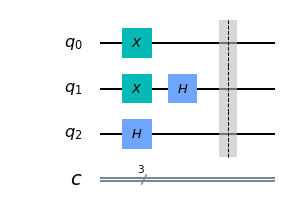

In [20]:
mybank = Bank()
n = 3

newnote = mybank.make_note(n, print_bb = True)
q = newnote.qubits
q.draw(output = 'mpl')

In [21]:
q.add_register(QuantumRegister(1, 'control'))

CNOTmX = [ [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, -1], [0, 0, -1, 0] ]
def Rd(delta):
    return [ [np.cos(delta), -np.sin(delta)], [np.sin(delta), np.cos(delta)]]

correct_bases = np.zeros(n, dtype = int)

In [22]:
from qiskit.quantum_info import Operator

# For each qubit
for i in range(n):
    
    # Let |a> be the bank note qubit whose basis we are trying to identify 
    
    for j in range(2):
        # If the |a> basis has already been identified, we can just move on the next !
        if correct_bases[i] == 1:
            continue 
        
        #### Trying to identify the basis of |a> ####
        
        # Clearing and setting control qubit |0>
        q.barrier()
        q.reset(n)
        
        N = 10 # The no. of steps/tests (higher means lower chance of being caught)
        delta = np.pi/(2*N)  # The angle by which 
        
        # Setting up N tests
        for _ in range(N):
            
            # Setting up roatation by using the U3 gate
            q.unitary(Operator(Rd(delta)), [n], label = "R_d")
            
            # If j = 0, we are trying to identify if |a> is |+>
            if j == 0:
                q.cx(n,i)
            # If j = 0, we are trying to identify if |a> is |->
            else:
                q.unitary(Operator(CNOTmX), [i,n], label = "CNOTmX")
            
            # Sending the note to bank for verifiication 
            #(measurement and collapse to correct state with high prob)
            q.barrier()
            mybank.verify_note(newnote)
        
        # After the N tests, we add a new register to measure the control qubit
        q.add_register(ClassicalRegister(1, 'cl_control'))
        
        # Performing the measurement
        q.measure([n],[n])
        
        backend = Aer.get_backend('qasm_simulator')
        result = execute(q, backend, shots=1, memory=True).result()
        
        print(result.get_memory())
        
        # Updating the answer if basis correctly identified
        correct_bases[i] = int(result.get_memory()[0][0])
        
        # Getting ready for the next iteration
        q.remove_final_measurements(inplace=True)

# Outputting the results
print(correct_bases)

['0 110']
['0 110']
['0 110']
['1 110']
['1 110']
[0 1 1]


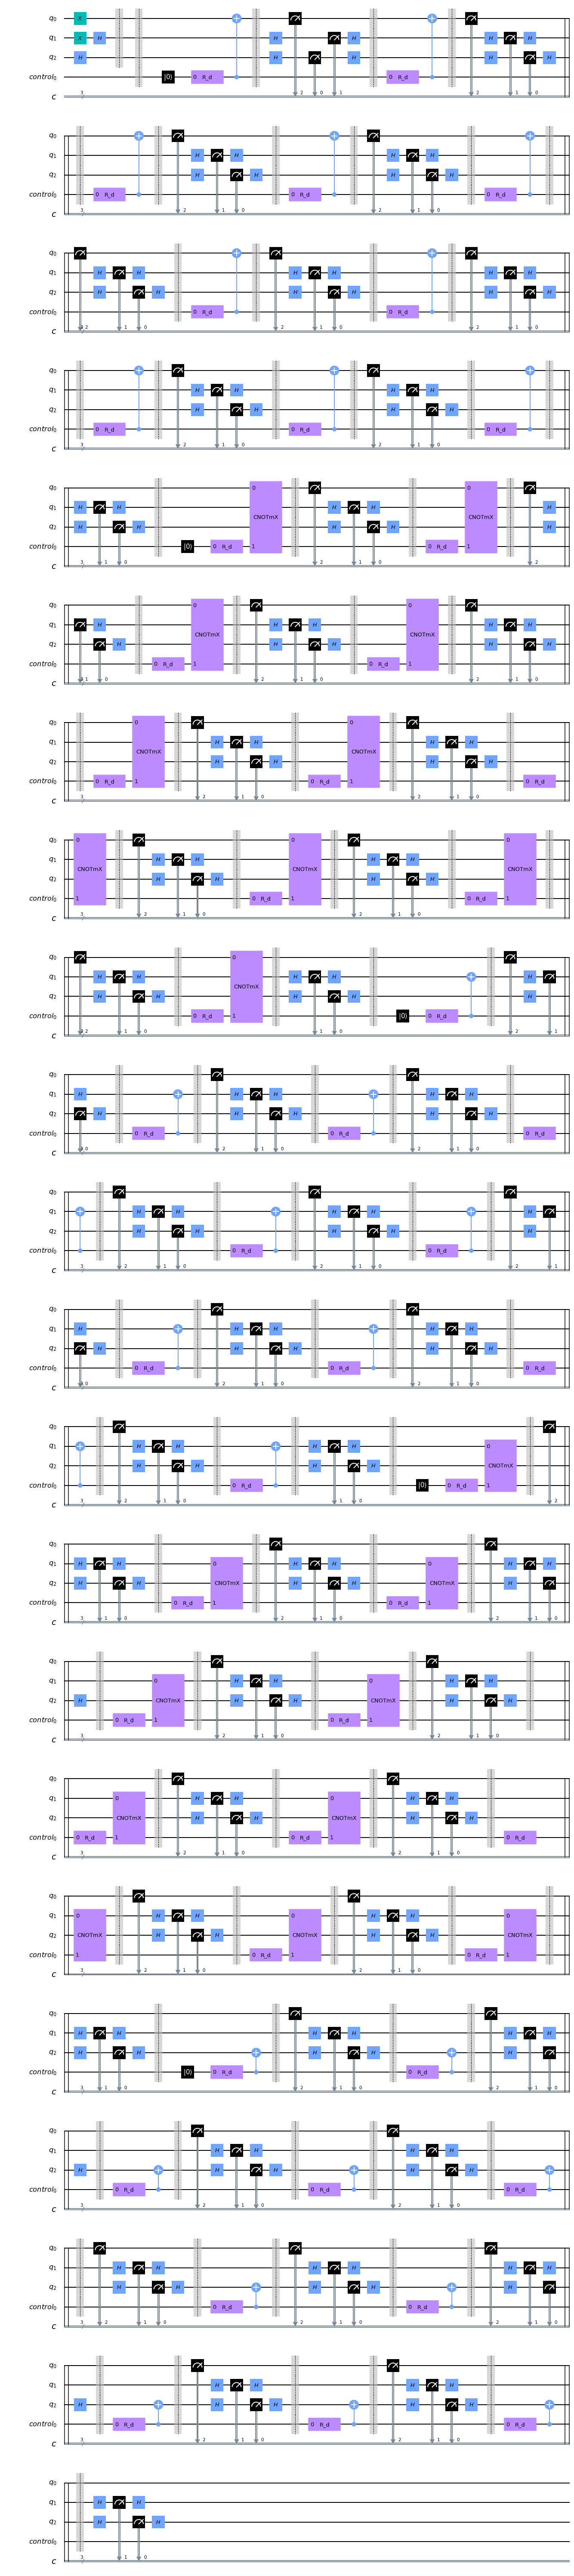

In [23]:
q.draw(output = 'mpl')

In [26]:
correct_bits   = measure_qubits(q, correct_bases)
correct_qubits = encode_qubits(correct_bits, correct_bases)
forged_note,_  = mybank.verify_note(Qnote(newnote.ser_no, correct_qubits), print_res = True)

The Bank has verified your note to be real. Here is your note back!


In [25]:
verified_note, _ = mybank.verify_note(newnote, print_res = True)

The Bank has verified your note to be real. Here is your note back!
